<a href="https://colab.research.google.com/github/nishgowda/ml-sandbox/blob/master/pytorch/lesson8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive



REBUILD_DATA = False
drive_path = "/content/drive/My Drive/Images/PetImages"
class DogsVCats():
	IMG_SIZE = 50
	CATS = f"{drive_path}/Cat"
	DOGS = f"{drive_path}/Dog"
	LABELS = {CATS : 0, DOGS : 1}
	training_data = []
	catcount = 0
	dogcount = 0
	
	def make_training_data(self):
		for label in self.LABELS:
			print(label)
			for f in tqdm(os.listdir(label)):
				try:
					path = os.path.join(label, f)
					img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
					img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
					self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
				
					if label == self.CATS:
						self.catcount += 1
					elif label == self.DOGS:
						self.dogcount += 1
				except Exception as e:
						pass
		np.random.shuffle(self.training_data)
		np.save("training_data.npy", self.training_data)
		print("Cats: ", self.catcount)
		print("Dogs: ", self.dogcount) 
if REBUILD_DATA:
	dogvcats = DogsVCats()
	dogvcats.make_training_data()

data_path = "/content/ml-sandbox/pytorch/"
training_data = np.load(f"{data_path}training_data.npy", allow_pickle=True)
#print(len(training_data))
#print(training_data[1])
#plt.imshow(training_data[1][0], cmap = "gray")
#plt.show()


class Net(nn.Module):
        def __init__(self):
                super().__init__()
                self.conv1 = nn.Conv2d(1, 32, 5)
                self.conv2 = nn.Conv2d(32, 64, 5)
                self.conv3 = nn.Conv2d(64, 128, 5)
                
                x = torch.randn(50,50).view(-1,1,50,50)
                self._to_linear = None
                self.convs(x)

                self.fc1 = nn.Linear(self._to_linear, 512)
                self.fc2 = nn.Linear(512, 2)

        def convs(self, x):
                x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
                x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
                x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
                
                #print(x[0].shape)
                if self._to_linear is None:
                        self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
                return x
        
        def forward(self, x):
                x = self.convs(x)
                x = x.view(-1, self._to_linear)
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
                return x

net = Net()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/225.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
#print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
#print(len(train_X))
#print(len(test_X))

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the GPU")
else:
  device = torch.device("cupa")
  print("running on the CPU")


running on the GPU


In [5]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [6]:
torch.cuda.device_count()

1

In [7]:
net = Net().to(device)

In [8]:
def train(net):
  BATCH_SIZE = 100
  EPOCHS = 3
  optimizer = optim.Adam(net.parameters(), lr = 0.001)
  loss_function = nn.MSELoss()
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
      batch_x = train_X[i:i+BATCH_SIZE].view(-1,1 ,50,50)
      batch_y = train_y[i:i+BATCH_SIZE]
      batch_x, batch_y = batch_x.to(device),batch_y.to(device),
      net.zero_grad()
      outputs = net(batch_x)
      loss = loss_function(outputs, batch_y)
      loss.backward()
      optimizer.step()

    print(f"epoch: {epoch}. Loss {loss}")

train(net)

  2%|▏         | 5/225 [00:00<00:04, 46.97it/s]

epoch: 0. Loss 0.22904177010059357


  2%|▏         | 5/225 [00:00<00:04, 48.62it/s]

epoch: 1. Loss 0.1736350804567337


100%|██████████| 225/225 [00:05<00:00, 41.89it/s]

epoch: 2. Loss 0.15273495018482208


In [9]:
def test(net):
  correct = 0 
  total = 0
  with torch.no_grad():
    for i in tqdm(range(len(test_X))):
      real_class = torch.argmax(test_y[i]).to(device)
      net_out = net(test_X[i].view(-1,1,50,50).to(device))[0]
      predicted_class = torch.argmax(net_out)
      if predicted_class == real_class:
        correct += 1
      total += 1
  print("Accuracy: ", round(correct/total, 3))
test(net)

100%|██████████| 2494/2494 [00:02<00:00, 942.20it/s]

Accuracy:  0.7


In [12]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()
def fwd_pass(X, y , train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)
  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

In [13]:
def test(size=32):
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

0.75 tensor(0.1494, device='cuda:0')


In [42]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                if i % 10 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
train(net)


100%|██████████| 225/225 [00:10<00:00, 21.78it/s]


['model-1592921350,1592921350.995, 0.47,0.5031, 0.75,0.3154model-1592921350,1592921351.041, 0.5,0.3153, 0.75,0.6246model-1592921350,1592921351.088, 0.49,0.5766, 0.75,0.2566model-1592921350,1592921351.138, 0.5,0.2552, 0.75,0.3127model-1592921350,1592921351.185, 0.51,0.3209, 0.75,0.359model-1592921350,1592921351.233, 0.46,0.3708, 0.75,0.3824model-1592921350,1592921351.277, 0.51,0.3833, 0.75,0.3907model-1592921350,1592921351.32, 0.47,0.3879, 0.75,0.3758model-1592921350,1592921351.365, 0.57,0.3745, 0.75,0.3656model-1592921350,1592921351.409, 0.52,0.3532, 0.75,0.3226model-1592921350,1592921351.45, 0.45,0.3235, 0.75,0.2841model-1592921350,1592921351.49, 0.44,0.2905, 0.75,0.2671model-1592921350,1592921351.532, 0.48,0.261, 0.75,0.2735model-1592921350,1592921351.574, 0.45,0.2724, 0.75,0.2893model-1592921350,1592921351.612, 0.45,0.3005, 0.75,0.3011model-1592921350,1592921351.651, 0.54,0.2896, 0.75,0.2774model-1592921350,1592921351.69, 0.51,0.2629, 0.75,0.2669model-1592921350,1592921351.728, 0.51

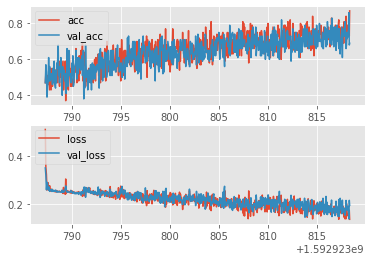

In [43]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = MODEL_NAME
def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().splitlines()
    print(contents)

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)